# Analyze Experiment Results

In [1]:
import pickle
import os
import sys

# include parent directory in path
parent_dir = os.path.abspath('../..')
sys.path.append(parent_dir)

if os.path.exists('clients.pkl'):
    with open('clients.pkl', 'rb') as file:
        clients = pickle.load(file)
else:
    print('No clients found')


In [2]:
# imports
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd


In [3]:
# load the metadata

# Initialize an empty dictionary to store the file content
metadata = {}

# Open the file and read line by line
with open('metadata.txt', 'r') as file:
    for line in file:
        # Strip white space and split by colon
        key, value = line.strip().split(': ')
        # Convert numerical values from strings
        if value.replace('.', '', 1).isdigit():
            if '.' in value:
                value = float(value)
            else:
                value = int(value)
        # Add to dictionary
        metadata[key] = value

# Print the dictionary
for key, value in metadata.items():
    if key == 'runtime':
        print(key, value/3600, 'hours')
    else:
        print(key, value)



gpu 0
dataset cifar10
shift 5_clusters
nbr_rounds 300
nbr_clients 100
n_data_train 400
n_data_val 100
seed 1
batch_size 8
nbr_local_epochs 1
lr 0.001
stopping_rounds 50
nbr_neighbors_sampled 5
prior_update_rule softmax
similarity_metric inverse_training_loss
cosine_alpha 0.0
tau 1.0
client_information_exchange DAC
experiment_name CIFAR_5_clusters_DAC_invloss_tau_1_seed_1
delusion 0.0
NAEM_frequency 5
T1 50
CIFAR_ratio 0.2
nbr_deluded_clients 0
measure_all_similarities True
mergatron chill
nbr_classes 10
nbr_channels 3
runtime 14.535496843457222 hours


In [4]:
# recreate the command used to run the experiment from the metadata
command = 'python3 run_experiment.py'
for key, value in metadata.items():
    command += f' --{key} {value}'
print(command)

python3 run_experiment.py --gpu 0 --dataset cifar10 --shift 5_clusters --nbr_rounds 300 --nbr_clients 100 --n_data_train 400 --n_data_val 100 --seed 1 --batch_size 8 --nbr_local_epochs 1 --lr 0.001 --stopping_rounds 50 --nbr_neighbors_sampled 5 --prior_update_rule softmax --similarity_metric inverse_training_loss --cosine_alpha 0.0 --tau 1.0 --client_information_exchange DAC --experiment_name CIFAR_5_clusters_DAC_invloss_tau_1_seed_1 --delusion 0.0 --NAEM_frequency 5 --T1 50 --CIFAR_ratio 0.2 --nbr_deluded_clients 0 --measure_all_similarities True --mergatron chill --nbr_classes 10 --nbr_channels 3 --runtime 52327.788636446


### Mergatron

In [5]:
if metadata['mergatron'] == 'activate':
    print('Mergatron activated')
    # read data from mergatron_stops.pkl
    with open('mergatron_stops.pkl', 'rb') as file:
        stops = pickle.load(file)
    
    # plot the stops
    plt.plot(stops)
    plt.xlabel('Round')
    plt.ylabel('Stops')
    plt.title('Mergatron Stops')
    plt.show()

### True similarities

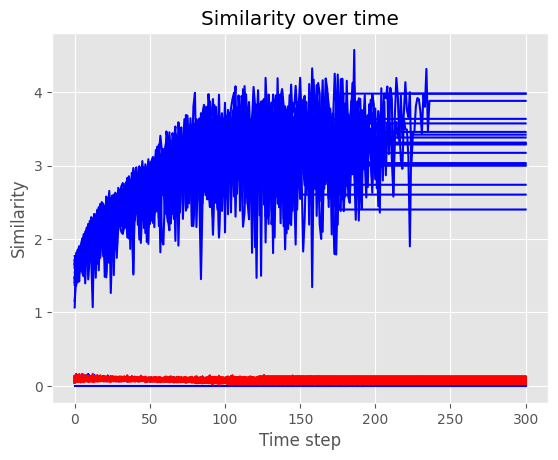

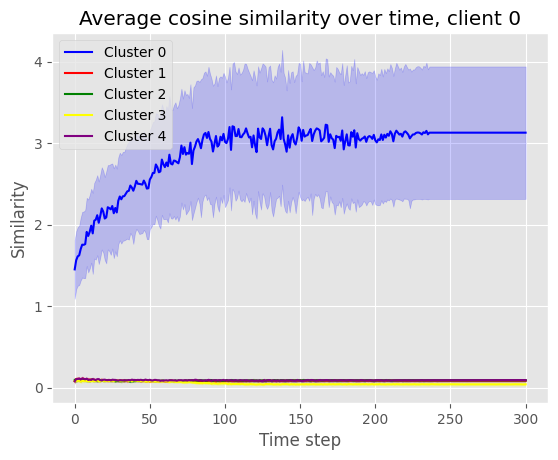

In [6]:
if 'measure_all_similarities' in metadata and metadata['measure_all_similarities']:
    k = 90
    client = clients[k]
    sims = client.true_similarities
    # sims is list of np arrays. Each array are similarities of a current time step
    # plot over time
    sims = np.array(sims)

    if metadata['dataset'] == 'PACS':
        # the first 25 clients should be the same color
        for i in range(10):
            idx = i
            plt.plot(sims[:, idx], label=f'Client {idx}', color='blue')
        for i in range(10):
            idx = i + 10
            plt.plot(sims[:, idx], label=f'Client {idx}', color='red')
        for i in range(10):
            idx = i + 20
            plt.plot(sims[:, idx], label=f'Client {idx}', color='green')
        for i in range(10):
            idx = i + 30
            plt.plot(sims[:, idx], label=f'Client {idx}', color='yellow')
    elif metadata['dataset'] == 'cifar10':
        for i in range(40):
            idx = i
            plt.plot(sims[:, idx], label=f'Client {idx}', color='blue')
        for i in range(40, 100):
            idx = i
            plt.plot(sims[:, idx], label=f'Client {idx}', color='red')
    #plt.legend()

    plt.xlabel('Time step')
    plt.ylabel('Similarity')
    plt.title('Similarity over time')
    plt.show()

    if metadata['dataset'] == 'PACS':
        # add another plot for the average similarity in each cluster of 10 over time, with the same colors and one standard deviation
        for i in range(4):
            idx = i * 10

            # remove index k from sims
            temp = np.delete(sims, k, axis=1)

            avg = np.mean(temp[:, idx:idx+10], axis=1)
            std = np.std(temp[:, idx:idx+10], axis=1)

            plt.plot(avg, label=f'Cluster {i}', color=['blue', 'red', 'green', 'yellow'][i])
            plt.fill_between(range(len(avg)), avg - std, avg + std, color=['blue', 'red', 'green', 'yellow'][i], alpha=0.2)
    elif metadata['dataset'] == 'cifar10':
        if metadata['shift'] == 'label':
            temp = np.delete(sims, k, axis=1)

            avg = np.mean(temp[:, 0:40], axis=1)
            std = np.std(temp[:, 0:40], axis=1)

            plt.plot(avg, label=f'Cluster 1', color='blue')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='blue', alpha=0.2)

            avg = np.mean(temp[:, 40:100], axis=1)
            std = np.std(temp[:, 40:100], axis=1)

            plt.plot(avg, label=f'Cluster 2', color='red')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='red', alpha=0.2)
            
        elif metadata['shift'] == '5_clusters':
            for i in range(5):
                idx = i * 20

                temp = np.delete(sims, k, axis=1)

                avg = np.mean(temp[:, idx:idx+20], axis=1)
                std = np.std(temp[:, idx:idx+20], axis=1)

                plt.plot(avg, label=f'Cluster {i}', color=['blue', 'red', 'green', 'yellow', 'purple'][i])
                plt.fill_between(range(len(avg)), avg - std, avg + std, color=['blue', 'red', 'green', 'yellow', 'purple'][i], alpha=0.2)

    elif metadata['dataset'] == 'fashion_mnist':
        temp = np.delete(sims, k, axis=1)

        if k == 0:
            avg = np.mean(temp[:, 0:69], axis=1)
            std = np.std(temp[:, 0:69], axis=1)

            plt.plot(avg, label=f'Cluster 1', color='blue')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='blue', alpha=0.2)

            avg = np.mean(temp[:, 69:89], axis=1)
            std = np.std(temp[:, 69:89], axis=1)

            plt.plot(avg, label=f'Cluster 2', color='red')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='red', alpha=0.2)

            avg = np.mean(temp[:, 89:94], axis=1)
            std = np.std(temp[:, 89:94], axis=1)

            plt.plot(avg, label=f'Cluster 3', color='green')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='green', alpha=0.2)

            avg = np.mean(temp[:, 94:99], axis=1)
            std = np.std(temp[:, 94:99], axis=1)

            plt.plot(avg, label=f'Cluster 4', color='yellow')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='yellow', alpha=0.2)

        if k == 70 or k == 90 or k == 95:
            avg = np.mean(temp[:, 0:70], axis=1)
            std = np.std(temp[:, 0:70], axis=1)

            plt.plot(avg, label=f'Cluster 1', color='blue')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='blue', alpha=0.2)

        if k == 70:

            avg = np.mean(temp[:, 70:89], axis=1)
            std = np.std(temp[:, 70:89], axis=1)

            plt.plot(avg, label=f'Cluster 2', color='red')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='red', alpha=0.2)

            avg = np.mean(temp[:, 89:94], axis=1)
            std = np.std(temp[:, 89:94], axis=1)

            plt.plot(avg, label=f'Cluster 3', color='green')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='green', alpha=0.2)

        elif k == 90 or k == 95:

            avg = np.mean(temp[:, 70:90], axis=1)
            std = np.std(temp[:, 70:90], axis=1)

            plt.plot(avg, label=f'Cluster 2', color='red')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='red', alpha=0.2)

        if k == 90:

            avg = np.mean(temp[:, 90:94], axis=1)
            std = np.std(temp[:, 90:94], axis=1)

            plt.plot(avg, label=f'Cluster 3', color='green')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='green', alpha=0.2)

        if k == 90 or k==70:

            avg = np.mean(temp[:, 94:99], axis=1)
            std = np.std(temp[:, 94:99], axis=1)

            plt.plot(avg, label=f'Cluster 4', color='yellow')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='yellow', alpha=0.2)
        
        elif k == 95:

            avg = np.mean(temp[:, 90:95], axis=1)
            std = np.std(temp[:, 90:95], axis=1)

            plt.plot(avg, label=f'Cluster 3', color='green')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='green', alpha=0.2)
    
            avg = np.mean(temp[:, 95:99], axis=1)
            std = np.std(temp[:, 95:99], axis=1)

            plt.plot(avg, label=f'Cluster 4', color='yellow')
            plt.fill_between(range(len(avg)), avg - std, avg + std, color='yellow', alpha=0.2)
        


    plt.legend()
    plt.xlabel('Time step')
    plt.ylabel('Similarity')
    plt.title('Average {} sim over time, client {}'.format(metadata['similarity_metric'], k))
    plt.show()

### Similarities over time

/tmp/ipykernel_556036/491410459.py:59: RuntimeWarning: divide by zero encountered in log2
  temp.append(-np.sum(row * np.log2(row)))
/tmp/ipykernel_556036/491410459.py:59: RuntimeWarning: invalid value encountered in multiply
  temp.append(-np.sum(row * np.log2(row)))


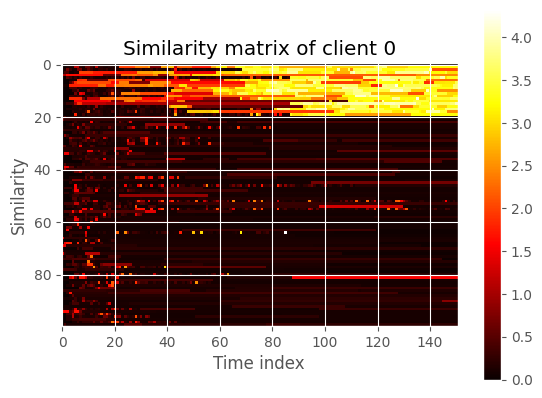

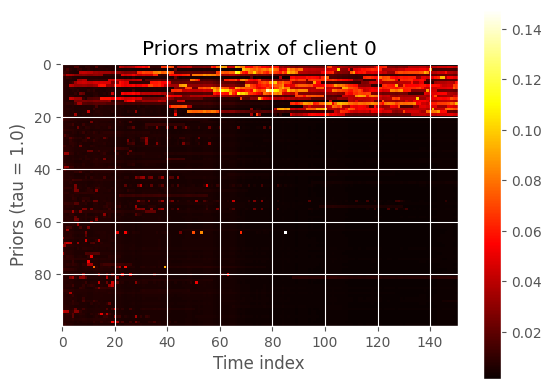

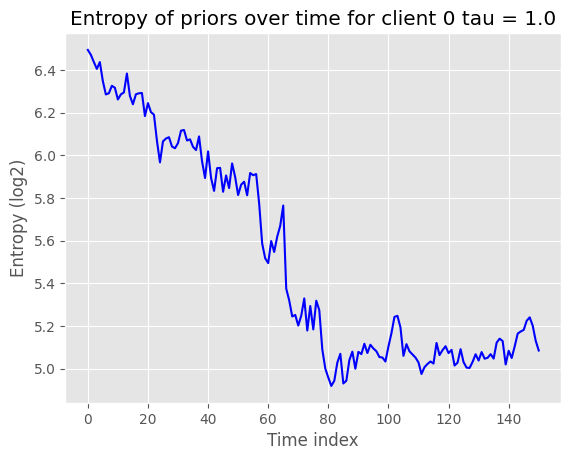

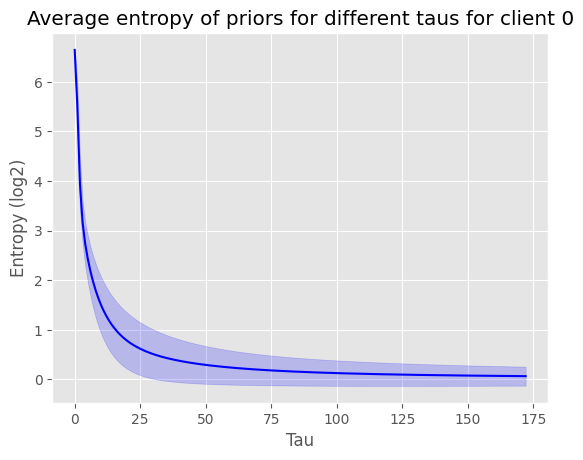

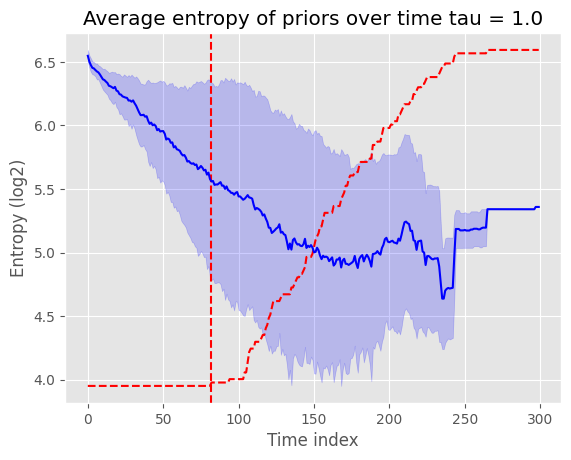

In [61]:
if metadata['client_information_exchange'] == 'DAC' or metadata['client_information_exchange'] == 'PANM':   
    # plot the similarities of client 0 with a heapmap, with the x-axis being the time index and the y-axis being the similarity
    client_number = 0
    similarity_matrix = clients[client_number].all_similarities
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.imshow(np.transpose(similarity_matrix), cmap='hot', interpolation='nearest')

    # add colorbar
    plt.colorbar()

    # add labels
    plt.xlabel('Time index')
    plt.ylabel('Similarity')

    # add title
    plt.title('Similarity matrix of client 0')
    plt.figure()
    if metadata['prior_update_rule'] == 'softmax':
        # For each row take the maximum value of that row and subtract it from all values in that row then take the softmax of that row with tau from the metadata
        priors_matrix = np.zeros_like(similarity_matrix)
        for row in range(len(similarity_matrix)):
            max_score = np.max(similarity_matrix[row])
            priors_matrix[row] = np.exp(np.array(similarity_matrix[row] - max_score) * metadata['tau'])/np.sum(np.exp(np.array(similarity_matrix[row] - max_score) * metadata['tau']))
        
        plt.imshow(priors_matrix, cmap='hot', interpolation='nearest')
        plt.imshow(np.transpose(priors_matrix), cmap='hot', interpolation='nearest')

        # add colorbar
        plt.colorbar()

        # add labels
        plt.xlabel('Time index')
        plt.ylabel('Priors (tau = {})'.format(metadata['tau']))

        # add title
        plt.title('Priors matrix of client 0')
        plt.figure()
        # Plot log2 entropy of priors every time step
        entropy = []
        for row in priors_matrix:
            entropy.append(-np.sum(row * np.log2(row)))
        plt.plot(entropy, color='blue')
        plt.xlabel('Time index')
        plt.ylabel('Entropy (log2)')
        plt.title('Entropy of priors over time for client {} tau = {}'.format(client_number, metadata['tau']))
    
    plt.figure()
    taus = np.array([x for x in range(200)])
    # for different taus calculate the average entropy for client client_number
    avg_entropy = []
    std_entropy = []
    for tau in taus:
        priors_matrix = np.zeros_like(similarity_matrix)
        for row in range(len(similarity_matrix)):
            max_score = np.max(similarity_matrix[row])
            priors_matrix[row] = np.exp(np.array(similarity_matrix[row] - max_score) * tau)/np.sum(np.exp(np.array(similarity_matrix[row] - max_score) * tau))
        temp = []
        for row in priors_matrix:
            temp.append(-np.sum(row * np.log2(row)))
        avg_entropy.append(np.mean(temp))
        std_entropy.append(np.std(temp))
    avg_entropy = np.array(avg_entropy)
    std_entropy = np.array(std_entropy)
    plt.plot(taus, avg_entropy, color='blue')
    plt.fill_between(taus, avg_entropy - std_entropy, avg_entropy + std_entropy, color='blue', alpha=0.2)
    plt.xlabel('Tau')
    plt.ylabel('Average Entropy (log2)')
    plt.title('Average entropy of priors for different taus for client {}'.format(client_number))


    plt.figure()    
    # Average entropy for all clients of the similarities over time
    entropy = []
    for client in clients:
        similarity_matrix = client.all_similarities
        priors_matrix = np.zeros_like(similarity_matrix)
        for row in range(len(similarity_matrix)):
            max_score = np.max(similarity_matrix[row])
            priors_matrix[row] = np.exp(np.array(similarity_matrix[row] - max_score) * metadata['tau'])/np.sum(np.exp(np.array(similarity_matrix[row] - max_score) * metadata['tau']))
        temp = []
        for row in priors_matrix:
            temp.append(-np.sum(row * np.log2(row)))
        entropy.append(temp)

    min_length = min([len(x) for x in entropy])
    # make all lists in entropy the same length as the longest list in entropy, add none to the lists that doesn't have the same length
    max_length = max([len(x) for x in entropy])
    entropy = [x + [None] * (max_length - len(x)) for x in entropy]
    
    # Take the average column by column in entropy but skip all none values
    avg_entropy = []
    std_entropy = []
    for i in range(max_length):
        temp = [x[i] for x in entropy if x[i] is not None]
        avg_entropy.append(np.mean(temp))
        std_entropy.append(np.std(temp))

    avg_entropy = np.array(avg_entropy)
    std_entropy = np.array(std_entropy)
    # Plot a cumalative graph of when each list in entropy reaches its first none value
    cumalative = []
    for i in range(max_length):
        temp = [x[i] for x in entropy]
        cumalative.append(temp.count(None))
    min_raise = np.min(avg_entropy - std_entropy)
    max_raise = np.max(avg_entropy + std_entropy)
    # scale cumulative to go between min raise and max raise
    cumalative = [min_raise + (max_raise - min_raise) * x / max(cumalative) for x in cumalative]
    
    plt.plot(cumalative, color='red', linestyle='--')

    # make a red dotted vertical line at the value of the shortest list in entropy
    plt.axvline(x=min_length, color='red', linestyle='--')
    
    plt.plot(avg_entropy, color='blue')
    plt.fill_between(range(len(avg_entropy)), avg_entropy - std_entropy, avg_entropy + std_entropy, color='blue', alpha=0.2)
    plt.xlabel('Time index')
    plt.ylabel('Entropy (log2)')
    plt.title('Average entropy of priors over time tau = {}'.format(metadata['tau']))

    
    # now plot the euclidean distance of two consecutive similarities in a new plot
    # convert similarity matrix to numpy array
    # similarity_matrix = np.array(similarity_matrix)
    # # transpose the matrix
    # similarity_matrix = np.transpose(similarity_matrix)
    # euclidean_distances = np.linalg.norm(similarity_matrix[:, 1:] - similarity_matrix[:, :-1], axis=0)
    # plt.plot(euclidean_distances)



### Who was sampled over time

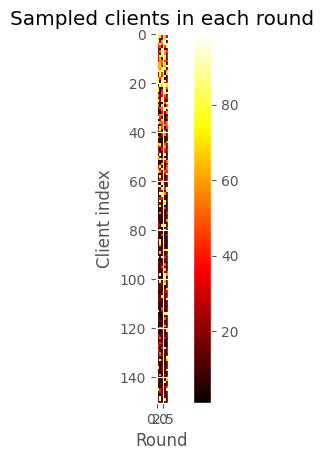

In [8]:
if metadata['client_information_exchange'] == 'DAC' or metadata['client_information_exchange'] == 'PANM':       
    sampled_list = clients[0].exchanges_every_round

    # sampled_list is a list of lists of who was sampled in each round

    # plot who was sampled in each round, with round on the x-axis and client index on the y-axis
    plt.figure()
    plt.imshow(sampled_list, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Round')
    plt.ylabel('Client index')
    plt.title('Sampled clients in each round')


### Early Stopping

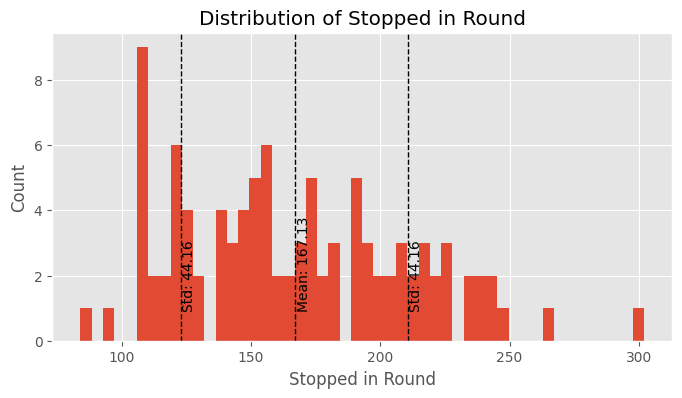

In [9]:
plt.figure(figsize=(8, 4))

stops = []
for client in clients:
    stops.append(len(client.val_acc_list))
plt.hist(stops, bins=50)
plt.xlabel('Stopped in Round')
plt.ylabel('Count')
plt.title('Distribution of Stopped in Round')

# plt mean and standard deviation
mean = np.mean(stops)
std = np.std(stops)
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.text(mean + .5, 1, 'Mean: {:.2f}'.format(mean), rotation=90)
plt.axvline(mean + std - .5, color='k', linestyle='dashed', linewidth=1)
plt.text(mean + std, 1, 'Std: {:.2f}'.format(std), rotation=90)
plt.axvline(mean - std, color='k', linestyle='dashed', linewidth=1)
plt.text(mean - std + .5, 1, 'Std: {:.2f}'.format(std), rotation=90)

plt.show()

### Validation Accuracy

In [10]:
# preprocess val acc lists - this is done such that for two accuracies plotted on the same index, POST EXCHANGE CAME FIRST

# pad each val_accs_post_exchange with two zeros in the beginning. One zero comes from the initial model validation without exchange and the other from the initial local training without exchange.
for client in clients:
    client.val_accs_post_exchange = [0] + client.val_accs_post_exchange

# now delete the end of each val_accs_post_exchange so that they are as long as val_acc_list for each client
for client in clients:
    client.val_accs_post_exchange = client.val_accs_post_exchange[:len(client.val_acc_list)]

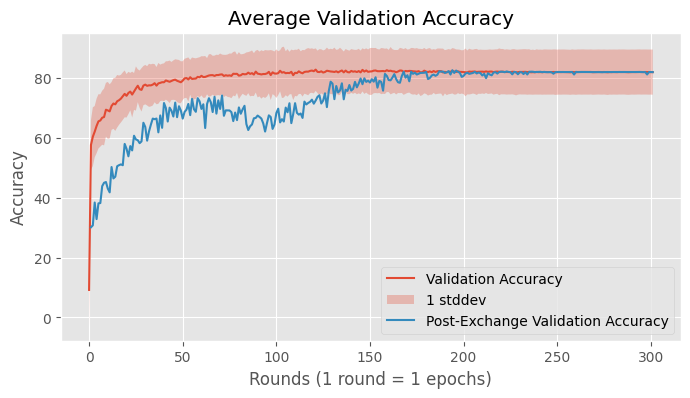

In [11]:
plt.figure(figsize=(8, 4))

# extend val_loss_list and val_accs_post_exchange for each client to be as long as the longest one
max_len = max([len(client.val_acc_list) for client in clients])
# pad end with last value
for client in clients:
    client.val_acc_list.extend([client.val_acc_list[-1]] * (max_len - len(client.val_acc_list)))
    client.val_accs_post_exchange.extend([client.val_accs_post_exchange[-1]] * (max_len - len(client.val_accs_post_exchange)))

avg_acc = np.mean([client.val_acc_list for client in clients], axis=0)
std_acc = np.std([client.val_acc_list for client in clients], axis=0)
plt.plot(avg_acc)
plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)

post_exchange_acc = np.mean([client.val_accs_post_exchange for client in clients], axis=0)

# plot post exchange accuracy, but dont display the first two values
plt.plot(range(1, len(post_exchange_acc)), post_exchange_acc[1:])

plt.xlabel('Rounds (1 round = {} epochs)'.format(metadata['nbr_local_epochs']))
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy')
plt.legend(['Validation Accuracy', '1 stddev','Post-Exchange Validation Accuracy'])


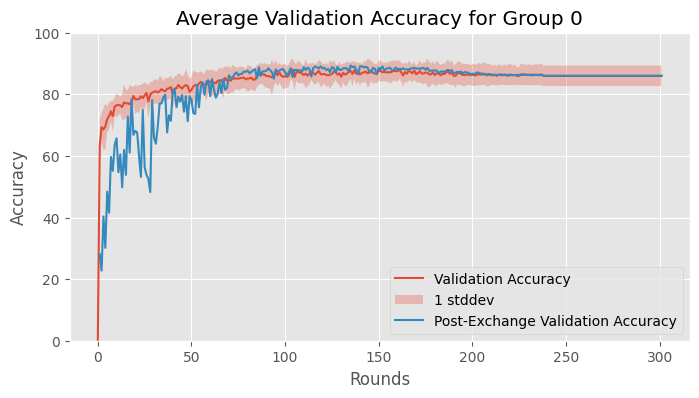

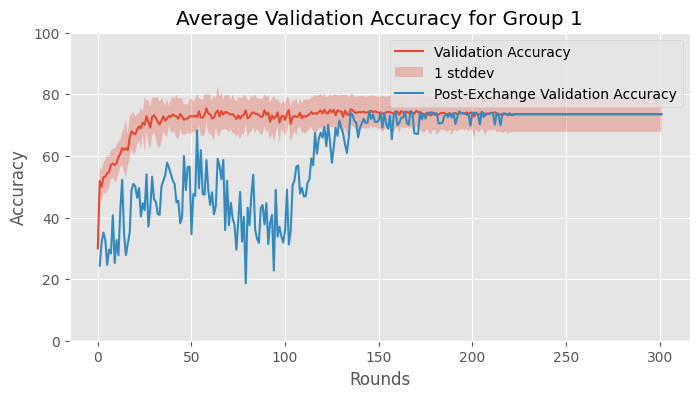

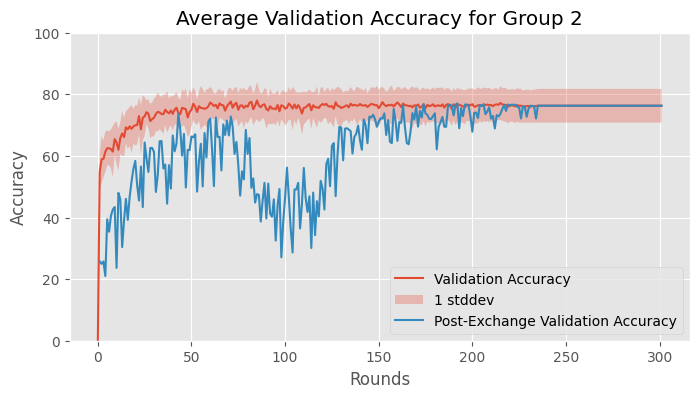

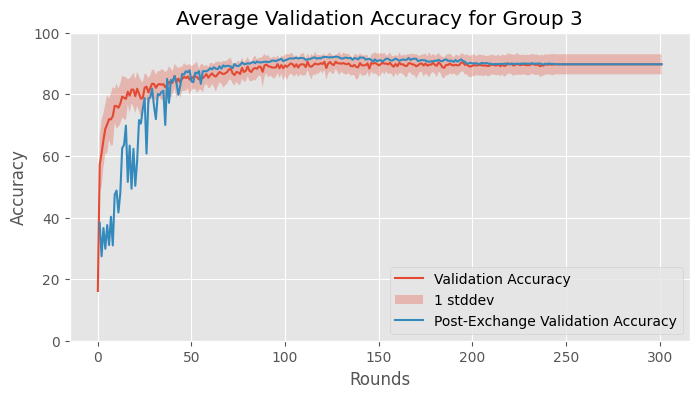

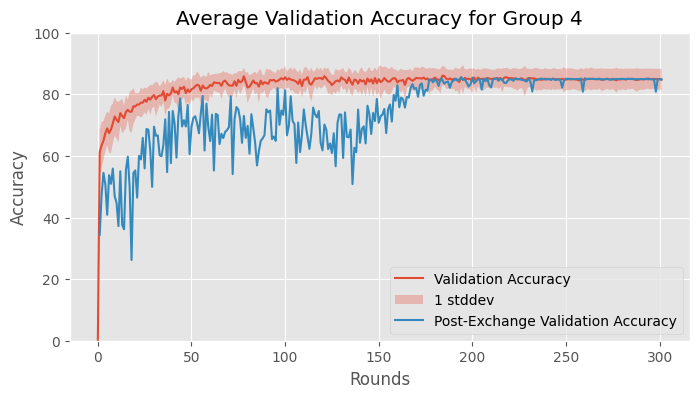

In [12]:
def plot_accuracy_per_group(group):
    plt.figure(figsize=(8, 4))

    avg_acc = np.mean([client.val_acc_list for client in clients if client.group == group], axis=0)
    std_acc = np.std([client.val_acc_list for client in clients if client.group == group], axis=0)
    plt.plot(avg_acc)
    plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)

    post_exchange_acc = np.mean([client.val_accs_post_exchange for client in clients if client.group == group], axis=0)

    # plot post exchange accuracy, but dont display the first two values
    plt.plot(range(1, len(post_exchange_acc)), post_exchange_acc[1:])

    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.title('Average Validation Accuracy for Group {}'.format(group))
    plt.legend(['Validation Accuracy', '1 stddev','Post-Exchange Validation Accuracy'])
    plt.ylim(0, 100)
    plt.show()

if metadata['dataset'] == 'cifar10':
    if metadata['shift'] == 'label':
        for i in range(2):
            plot_accuracy_per_group(i)
    if metadata['shift'] == '5_clusters':
        for i in range(5):
            plot_accuracy_per_group(i)
elif metadata['dataset'] == 'PACS':
    for i in range(4):
        plot_accuracy_per_group(i)
elif metadata['dataset'] == 'fashion_mnist':
    for i in range(4):
        plot_accuracy_per_group(i)

### Validation and Training Loss

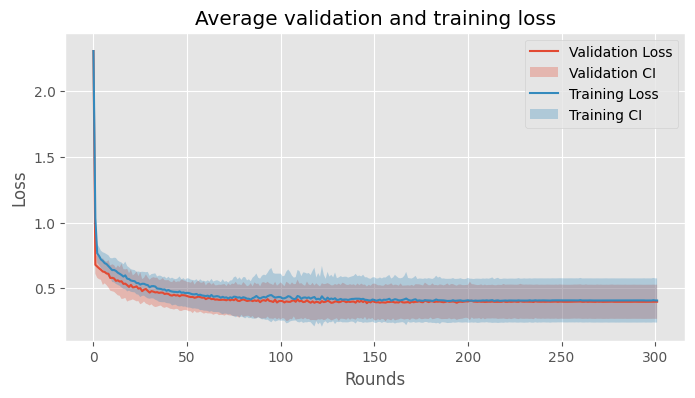

In [13]:
plt.figure(figsize=(8, 4))

# extend val_loss_list for each client to be as long as the longest one
max_len = max([len(client.val_loss_list) for client in clients])
# pad end with last value
for client in clients:
    client.val_loss_list.extend([client.val_loss_list[-1]] * (max_len - len(client.val_loss_list)))

# extend train_loss_list for each client to be as long as the longest one
max_len = max([len(client.train_loss_list) for client in clients])
# pad end with last value
for client in clients:
    client.train_loss_list.extend([client.train_loss_list[-1]] * (max_len - len(client.train_loss_list)))

avg_val_loss = np.mean([client.val_loss_list for client in clients], axis=0)
std_val_loss = np.std([client.val_loss_list for client in clients], axis=0)
plt.plot(avg_val_loss)
plt.fill_between(range(len(avg_val_loss)), avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, alpha=0.3)
plt.xlabel('Rounds')
plt.ylabel('Loss')

avg_train_loss = np.mean([client.train_loss_list for client in clients], axis=0)
std_train_loss = np.std([client.train_loss_list for client in clients], axis=0)
plt.plot(avg_train_loss)
plt.fill_between(range(len(avg_train_loss)), avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, alpha=0.3)

plt.title('Average validation and training loss')
plt.legend(['Validation Loss', 'Validation CI', 'Training Loss', 'Training CI'])
plt.show()

### Heatmaps

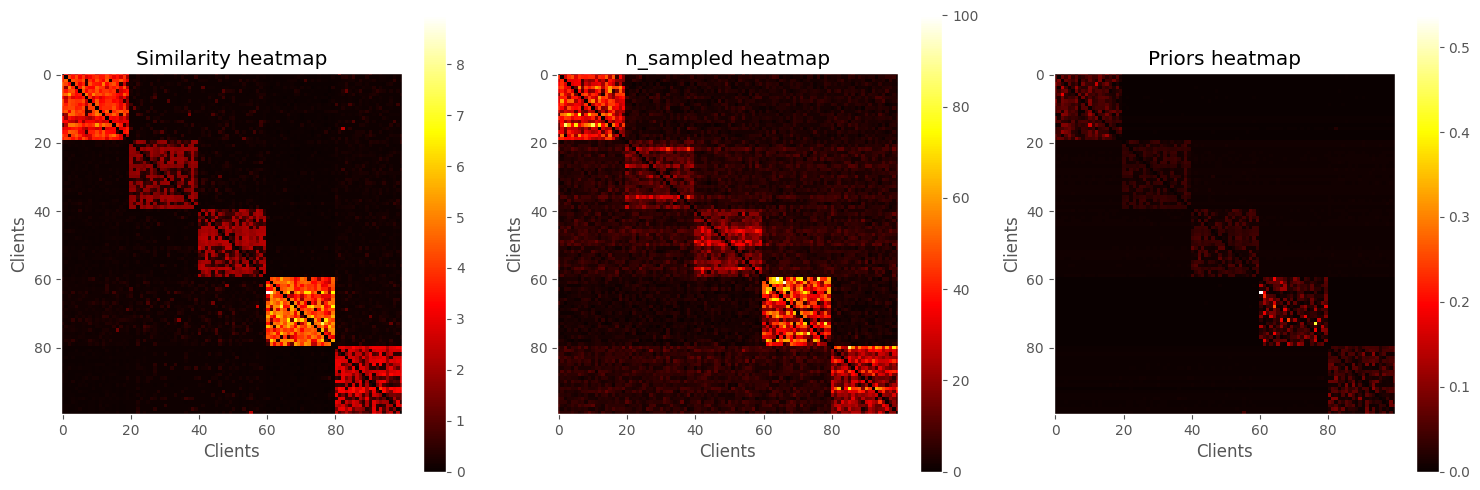

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Similarity heatmap
similarity_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    similarity_matrix[i] = client.similarity_scores
im = axes[0].imshow(similarity_matrix, cmap='hot', interpolation='nearest')
axes[0].set_title('Similarity heatmap')
axes[0].set_xlabel('Clients')
axes[0].set_ylabel('Clients')
fig.colorbar(im, ax=axes[0])


# n_sampled heatmap
n_sampled_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    n_sampled_matrix[i] = client.n_sampled
im = axes[1].imshow(n_sampled_matrix, cmap='hot', interpolation='nearest')
axes[1].set_title('n_sampled heatmap')
axes[1].set_xlabel('Clients')
axes[1].set_ylabel('Clients')
fig.colorbar(im, ax=axes[1])

# priors heatmap
priors_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    priors_matrix[i] = client.priors
im = axes[2].imshow(priors_matrix, cmap='hot', interpolation='nearest')
axes[2].set_title('Priors heatmap')
axes[2].set_xlabel('Clients')
axes[2].set_ylabel('Clients')
fig.colorbar(im, ax=axes[2])

# turn off grid
for ax in axes:
    ax.grid(False)

plt.tight_layout()
plt.show()


### Cluster-wise accuracies

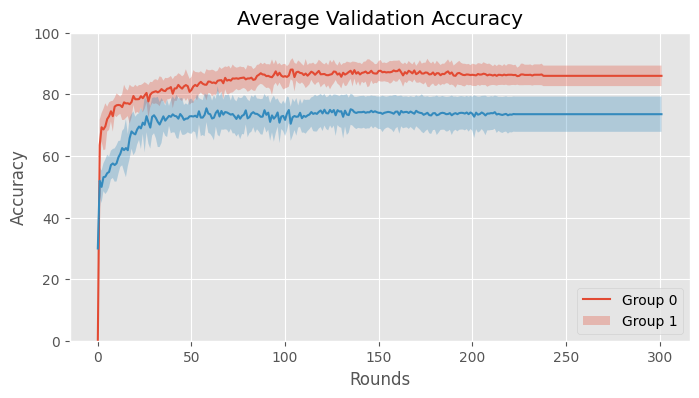

In [15]:
plt.figure(figsize=(8, 4))

if metadata['dataset'] == 'cifar10':
    nbr_groups = 2
elif metadata['dataset'] == 'PACS':
    nbr_groups = 4
elif metadata['dataset'] == 'fashion_mnist':
    nbr_groups = 4
    
for group in range(nbr_groups):
    avg_acc = np.mean([client.val_acc_list for client in clients if client.group == group], axis=0)
    std_acc = np.std([client.val_acc_list for client in clients if client.group == group], axis=0)
    plt.plot(avg_acc)
    plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)
    
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy')
plt.ylim(0, 100)
legend = ['Group {}'.format(i) for i in range(nbr_groups)]
plt.legend(legend)
plt.show()

### ___________________________________________________________________________________________________________

# Performance on Test Set

In [16]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from utils.classes import DatasetSplit
from torch.utils.data import DataLoader

if metadata['dataset'] == 'cifar10':
    what_data = 'CIFAR'
    print('Call separate script to test PACS')
    print('run: python3 test_CIFAR.py --experiment {}'.format(metadata['experiment_name']))

if metadata['dataset'] == 'PACS':
    what_data = 'PACS'
    print('Call separate script to test PACS')
    print('run: python3 test_PACS.py --experiment {} --quick'.format(metadata['experiment_name'])) # quick flag to disable cross-cluster testing


Call separate script to test PACS
run: python3 test_CIFAR.py --experiment CIFAR_5_clusters_DAC_invloss_tau_1_seed_1


80
80
20
20
Zero on Zero: 20.30 +/- 11.91
Zero on One: 10.57 +/- 18.30
One on Zero: 0.00 +/- 0.01
One on One: 44.65 +/- 0.37


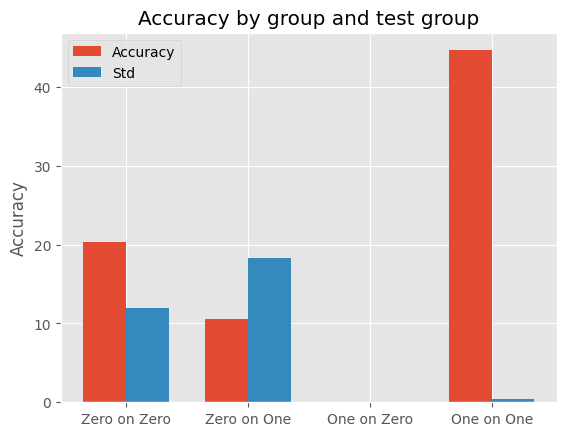

In [17]:
if what_data == 'CIFAR':
    with open('CIFAR_A_within.pkl', 'rb') as file:
        zero_on_zero = pickle.load(file)
    with open('CIFAR_A_on_V.pkl', 'rb') as file:
        zero_on_one = pickle.load(file)
    with open('CIFAR_V_on_A.pkl', 'rb') as file:
        one_on_zero = pickle.load(file)
    with open('CIFAR_V_within.pkl', 'rb') as file:
        one_on_one = pickle.load(file)

    print(len(zero_on_zero))
    print(len(zero_on_one))
    print(len(one_on_zero))
    print(len(one_on_one))
    # print mean and std
    print('Zero on Zero: {:.2f} +/- {:.2f}'.format(np.mean(zero_on_zero), np.std(zero_on_zero)))
    print('Zero on One: {:.2f} +/- {:.2f}'.format(np.mean(zero_on_one), np.std(zero_on_one)))
    print('One on Zero: {:.2f} +/- {:.2f}'.format(np.mean(one_on_zero), np.std(one_on_zero)))
    print('One on One: {:.2f} +/- {:.2f}'.format(np.mean(one_on_one), np.std(one_on_one)))

    # plot barplot of mean and std
    if metadata['shift'] == 'label':
        fig, ax = plt.subplots()
        x = np.arange(4)
        width = 0.35
        rects1 = ax.bar(x - width/2, [np.mean(zero_on_zero), np.mean(zero_on_one), np.mean(one_on_zero), np.mean(one_on_one)], width, label='Accuracy')
        rects2 = ax.bar(x + width/2, [np.std(zero_on_zero), np.std(zero_on_one), np.std(one_on_zero), np.std(one_on_one)], width, label='Std')

        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy by group and test group')
        ax.set_xticks(x)
        ax.set_xticklabels(['Zero on Zero', 'Zero on One', 'One on Zero', 'One on One'])

        ax.legend()
        plt.show()



In [18]:
if what_data == 'PACS':
    # load acc_matrix from PACS_acc_matrix.pkl
    with open('PACS_acc_matrix.pkl', 'rb') as file:
        acc_matrix = pickle.load(file)

    mean_matrix = np.mean(acc_matrix, axis=2)
    std_matrix = np.std(acc_matrix, axis=2)

    # make heatmap of test with colorbar and lava colormap
    fig, ax = plt.subplots()
    im = ax.imshow(mean_matrix, cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Photo', 'Art', 'Cartoon', 'Sketch'])
    ax.set_yticklabels(['Photo', 'Art', 'Cartoon', 'Sketch'])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(4):
        for j in range(4):
            text = ax.text(j, i, '{:.2f}'.format(mean_matrix[i, j]),
                        ha="center", va="center", color="w")

    ax.set_title("Accuracy of each group on each test set")
    fig.tight_layout()

    # set xlabel
    ax.set_xlabel('Group')
    ax.set_ylabel('Test set')

    # remove grid
    ax.grid(False)
    plt.show()


In [19]:
if what_data == 'PACS':
    # load acc_matrix from PACS_acc_matrix.pkl
    with open('PACS_acc_matrix.pkl', 'rb') as file:
        acc_matrix = pickle.load(file)

    mean_matrix = np.mean(acc_matrix, axis=2)
    std_matrix = np.std(acc_matrix, axis=2)

    # make heatmap of test with colorbar and lava colormap
    fig, ax = plt.subplots()
    im = ax.imshow(std_matrix, cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Photo', 'Art', 'Cartoon', 'Sketch'])
    ax.set_yticklabels(['Photo', 'Art', 'Cartoon', 'Sketch'])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(4):
        for j in range(4):
            text = ax.text(j, i, '{:.2f}'.format(std_matrix[i, j]),
                        ha="center", va="center", color="w")

    ax.set_title("Standard deviation of accuracy of each group on each test set")
    fig.tight_layout()

    # set xlabel
    ax.set_xlabel('Group')
    ax.set_ylabel('Test set')

    # remove grid
    ax.grid(False)
    plt.show()


In [20]:
if what_data == 'PACS':
    # print mean matrix with commas as separator
    print('Mean matrix:')
    for row in mean_matrix:
        print(','.join([str(round(x, 2)) for x in row]))
if what_data == 'CIFAR':
    excel_list = [np.mean(zero_on_zero), np.mean(one_on_one), np.mean(zero_on_one), np.mean(one_on_zero), np.std(zero_on_zero), np.std(one_on_one), np.std(zero_on_one), np.std(one_on_zero)]
    # print mean matrix with commas as separator
    print('Mean and std list:')
    print(','.join([str(round(e, 2)) for e in excel_list]))
    

Mean and std list:
20.3,44.65,10.57,0.0,11.91,0.37,18.3,0.01


In [21]:
# print std matrix with commas as separator
if what_data == 'PACS':
    print('Std matrix:')
    for row in std_matrix:
        print(','.join([str(round(x, 2)) for x in row]))